TO-DO
    -Include keyword synonyms in TF-IDF
    -Should we stem the targets and input text?
    -POS and structure
    -The paragraphs need to be rolled up by Policy Area/Sector
    xAdd n-gram catcher (maybe replace origional text with de-spaced ngram)
    -Should script just make one large df and do lookups?
    -Dynamic section discovery (script is able to identify Executive Summary on its own)

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
import matplotlib.pyplot as plt
% matplotlib inline
import nltk
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid',font="calibri")
#sns.set(style="white)

stemmer = PorterStemmer()
dir = 'C:\\Users\\Travis Park\\Google Drive\\UN\\Team MOZART RAP\\'

In [2]:
SDG_Targets = pd.read_excel(dir +'SDG.xlsx', names = ['ID', 'Target'],sheetname = 'Sheet1')

In [3]:
SDG_Targets.head()

,ID,Target
0,1.2,"By 2030, reduce at least by half the proporti..."
1,1.3,Implement nationally appropriate social prote...
2,1.4,"By 2030, ensure that all men and women, in pa..."
3,1.5,"By 2030, build the resilience of the poor and..."
4,2.1,"By 2030, end hunger and ensure access by all ..."


In [4]:
#writes country SDG report to list 'f' split by paragraph
f = open(dir + 'Bhutan_doc_test.txt', 'r')
f = f.read().replace('. \n\n','.\n\n').split('.\n\n')
f = [w.replace('\n',' ') for w in f]
for w in f:
    if len(w) <= 100:
        f.remove(w)
    w = stemmer.stem(w)

In [5]:
len(f)

1049

In [6]:
input_text = f

In [7]:
vectorizer =TfidfVectorizer(stop_words='english', lowercase = True, ngram_range=(1,3), max_df=0.9, min_df= 0.1) 

d_columns = ['Paragraph','Text','Target','Target_Text','CosineSimilarity']

d = pd.DataFrame(columns = d_columns)

def match_to_target(inputlist,paragraphnumber):   
    #runs tfidf vectorizer with paragraph against all targets, returns the target with highest cosine similarity
    global d    
    add_paragraph(inputlist,paragraphnumber)
    x = vectorizer.fit_transform(inputlist)
    y = pd.DataFrame((x * x.T).A)
    z = len(inputlist)-1
    y1 = max(y[(y[z] < 0.999999)][z])
    y_value = y[z].loc[y[z] == y1].index.tolist()
    y_value = y_value[0]   
    
    indx = SDG_Targets.loc[SDG_Targets['Target']==inputlist[y_value]]['ID'].tolist()
    indx = indx[0]
    indx_text = SDG_Targets.loc[SDG_Targets['ID']==indx]['Target'].tolist()
    indx_text = indx_text[0]
    
    d1 = pd.DataFrame([[paragraphnumber,inputlist[len(inputlist)-1],indx, indx_text, y1]], columns = d_columns)
    d =pd.concat([d,d1])
    
    
targets = []

def process_targets(df_targets):
    #appends all targets in file to a dataframe

    targets.clear()
    b = 0
    while b < len(df_targets):
        targets.append(df_targets['Target'][b])
        b=b+1

flag=0

def add_paragraph(inputlist,paragraphnumber):
    #adds one paragraph to list of targets
    global flag
    if flag == 1:#if a paragraph has already been appended, replace it with a new one
        inputlist[len(inputlist)-1] = input_text[paragraphnumber]
    elif flag == 0:#if no paragraph has been appended, add a new one
        targets.append(input_text[0])
        flag = 1

In [8]:
process_targets(SDG_Targets)

In [9]:
i=0
while i < len(input_text):
    match_to_target(targets,i)
    i=i+1

In [10]:
d.head()

,Paragraph,Text,Target,Target_Text,CosineSimilarity
0,0.0,Eleventh Five Year Plan - Main Document Volume...,14.5,"By 2020, conserve at least 10 per cent of coa...",0.721465
0,1.0,ISBN 978-99936-55-01-5 Eleventh Five Year ...,1.2,"By 2030, reduce at least by half the proporti...",0.000000
0,2.0,The government has provided education to our y...,3.8,"Achieve universal health coverage, including ...",0.814433
0,3.0,The recent Rupee shortage is a serious proble...,1.2,"By 2030, reduce at least by half the proporti...",0.000000
0,4.0,- His Majesty The King’s address to the nat...,14.5,"By 2020, conserve at least 10 per cent of coa...",0.721465


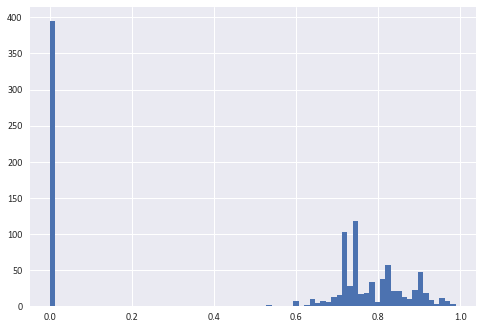

In [11]:
d['CosineSimilarity'].hist(bins = 75)

In [12]:
d.to_csv(dir + 'TFIDF.csv')

In [13]:
e = d[(d.Target == 17.14)]

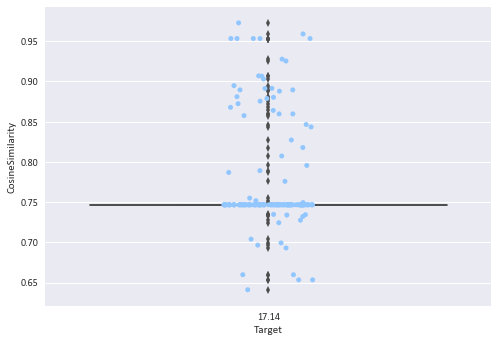

In [14]:
c = sns.boxplot(x="Target", y="CosineSimilarity", data=e, color = 'grey')
c = sns.stripplot(x="Target", y="CosineSimilarity", data=e, jitter=True, edgecolor="gray",palette="pastel")

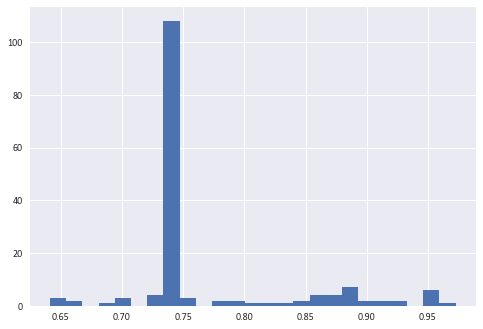

In [15]:
e['CosineSimilarity'].hist(bins = 25)

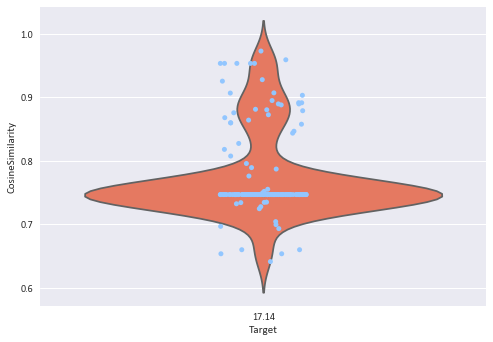

In [16]:
sns.violinplot(x="Target", y="CosineSimilarity", data=e, size=5,palette="Reds_r")
sns.stripplot(x="Target", y="CosineSimilarity", data=e, jitter=True, edgecolor="gray", palette="pastel")

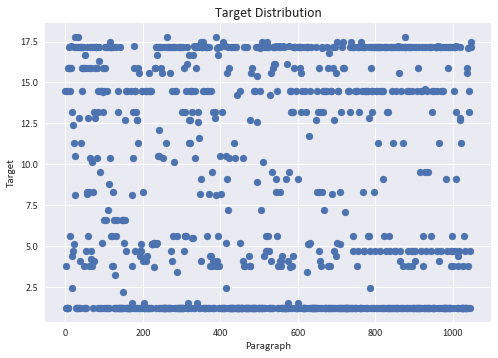

In [17]:
plt.scatter(x = d['Paragraph'], y = d['Target'])
plt.xlabel('Paragraph', fontsize=11)
plt.ylabel('Target', fontsize=11)
plt.title('Target Distribution', fontsize=14)